In [38]:
import numpy as np 
import pandas as pd
import random as rm
import math
import matplotlib.pyplot as plt
# shift + enter to run cells
# python3 -m pip install til at installere moduler
# control stjerne for at gøre hele linjen til en kommentar

# Simulations of particle trajectories

(10, 100)

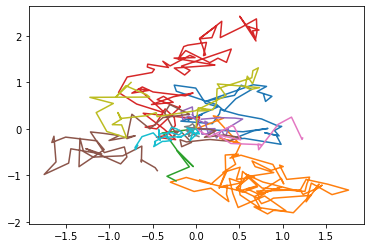

In [39]:
x0 = 0 
y0 = 0
num_tracks = 10
min_tlength = 5
max_tlength = 100
track_length = np.random.randint(min_tlength,max_tlength,size=num_tracks) 
#print(track_length)

D_track = np.random.uniform(low = 10**-3, high = 1, size=(num_tracks))
#print(D_track)
# D = np.reshape(np.repeat(D_track,track_length),(num_tracks,track_length))
dt = 1/30 # ca. 36 milli sec irl, kameratid åbent 

tracks_x = []
tracks_y = []
extend_list = []

for i in range(num_tracks):
    D = D_track[i]
    l = track_length[i]
    extend = np.repeat(0,max_tlength-1-track_length[i],axis = None)
    extend_list.append(len(extend))
    # print(extend_list)
    #print(D)
    
    two_D_t = 2*D*dt
    # pixel i kameraet = 180 nm, 220 pixels 
    step_x = np.random.normal(loc=0.0, scale=np.sqrt(two_D_t), size=l)
    #print(step_x)
    step_y = np.random.normal(loc=0.0, scale=np.sqrt(two_D_t), size=l)
    #print(step_y)
    
    def sim1 (x,y,step_x,step_y):
        y_f = np.concatenate([[y],np.cumsum(step_y)])
        x_f = np.concatenate([[x],np.cumsum(step_x)])
        return np.array([x_f,y_f])
    location = sim1(x0,y0,step_x,step_y)
    location_x = location[0]
    location_y = location[1]
    
    extend_location_x = np.insert(location_x,0,extend)
    extend_location_y = np.insert(location_y,0,extend)
    
    tracks_x.append(extend_location_x)
    tracks_y.append(extend_location_y)
    
    #plt.figure()
    plt.plot(location[0],location[1])   

data_x = np.array(tracks_x)
data_y = np.array(tracks_y)

data_x.shape

# tracks indeholder x og y for et track. Dvs hvis man kalder index 80, så får man track 80 ud af 100. 

# Machine learning with GPR

In [40]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
X = data_x
#D_opti = np.repeat(D_track[0],track_length,axis = None)
#print(D_opti)
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e5))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X,D_track)
gx = gaussian_process.predict(data_y)
gx, D_track

(array([1.60542716e-011, 1.30051987e-196, 7.40093007e-006, 8.08067745e-180,
        2.31045257e-004, 3.18630432e-007, 7.06203840e-002, 9.73181313e-002,
        9.69671433e-019, 3.36321306e-003]),
 array([0.76650122, 0.61766756, 0.67518849, 0.5789263 , 0.19210992,
        0.55848183, 0.5571349 , 0.00996894, 0.89430561, 0.13778563]))

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
Y = data_y
#D_opti = np.repeat(D_track[0],track_length,axis = None)
#print(D_opti)
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(Y,D_track)
gy = gaussian_process.predict(data_x)
gy, D_track

(array([0.36864061, 0.00061546, 0.32535269, 0.15052355, 0.17604679,
        0.03457497, 0.29584019, 0.04575663, 0.40014883, 0.48561916]),
 array([0.76650122, 0.61766756, 0.67518849, 0.5789263 , 0.19210992,
        0.55848183, 0.5571349 , 0.00996894, 0.89430561, 0.13778563]))

In [42]:
result = np.add(gx,gy)/2

mse_1 = np.mean((result-D_track)**2)
from sklearn.metrics import mean_squared_error
mse_2 = mean_squared_error(D_track,result)

print(mse_1, mse_2)

# D_track varierede fra 10**-3 til 1
# Mean squared error på 0,1 er sådan... ret stort.

# Vi benytter mean squared displacement i stedet for accuracy på vores model der har trænet på validation data, da det er regression.

0.217705010929886 0.217705010929886


# Fit for mean squared displacement (MSD)

434


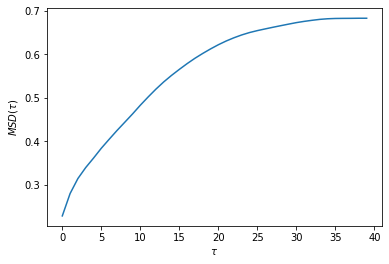

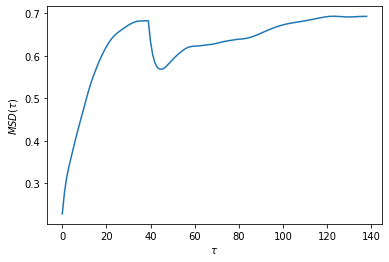

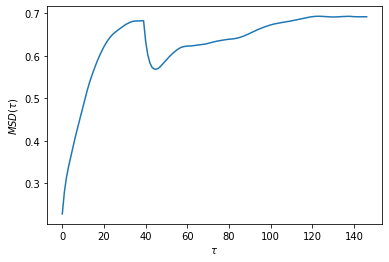

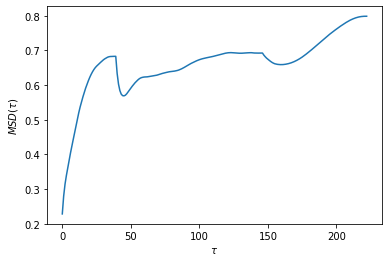

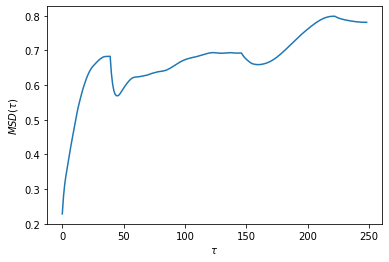

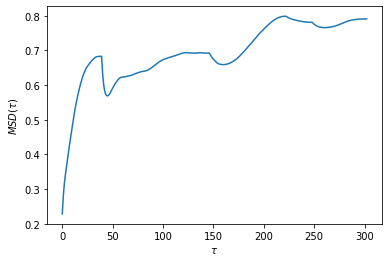

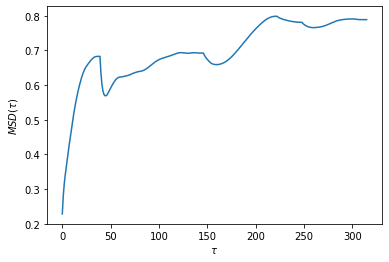

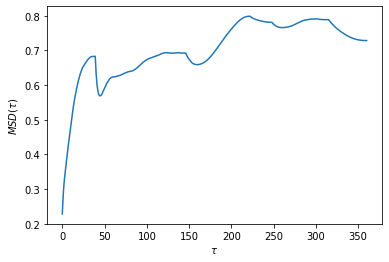

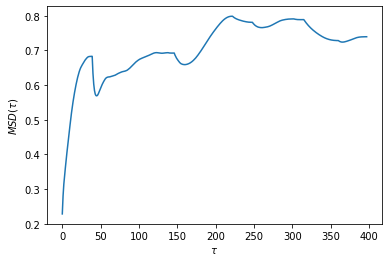

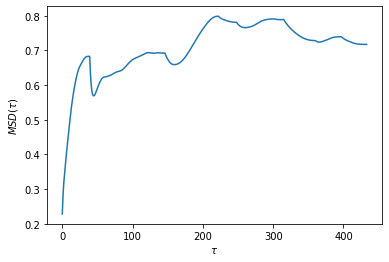

In [43]:
dix_list = []
diy_list = []
MSD_list = []
lag_list = []

for h in range(num_tracks):
    lag = np.array(range(1,100-extend_list[h]))
    lag_list.append(lag)
    for i in range(len(lag_list[h])):
        for j in range(1,max_tlength-extend_list[h]-lag_list[h][i]):
            diff_x = X[h][extend_list[h]+j+lag_list[h][i]] - X[h][extend_list[h]+j]
            diff_y = Y[h][extend_list[h]+j+lag_list[h][i]] - Y[h][extend_list[h]+j]
            dix_list.append(diff_x)
            diy_list.append(diff_y)
        MSD = np.mean(np.sqrt(np.array([dix_list])**2+np.array([diy_list])**2))
        MSD_list.append(MSD)
    plt.figure()
    plt.plot(MSD_list)
    plt.ylabel('$MSD(τ)$')
    plt.xlabel('$ τ $')

print(len(MSD_list))
    
# slope/4 = Diffusion coefficient